# TNK126 - CBA Exercise 2 (congestion tax)

Socio-economically optimal congestion charge, i.e., static/non-dynamic congestion function, limited externalities.

In [39]:
import numpy as np # type: ignore
import matplotlib.pyplot as plt
from scipy.optimize import minimize_scalar # type: ignore

## No congestion, no tax

### Inverse demand function

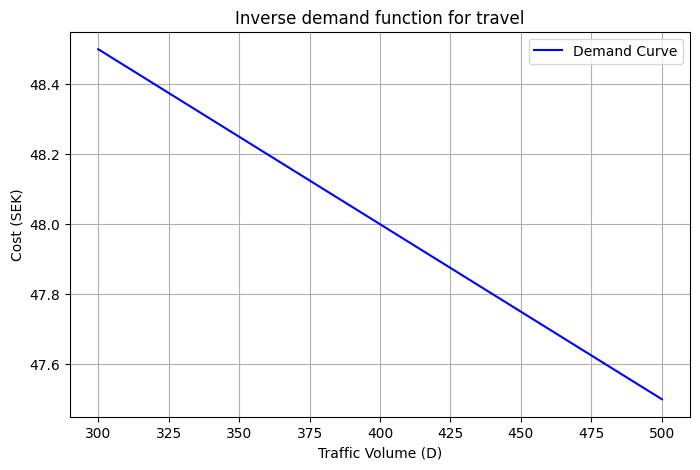

In [40]:
# Demand function (example: linear demand)
def demand_function(GK0, slope, D_max):
    D_values = np.linspace(300, D_max, 50)
    GK_values = GK0 - slope * D_values
    return D_values, GK_values

# Plot demand function
selected_slop = 0.005
selected_GK0 = 50
D_vals, GK_vals = demand_function(GK0=selected_GK0, slope=selected_slop, D_max=500)
plt.figure(figsize=(8, 5))
plt.plot(D_vals, GK_vals, label='Demand Curve', color='b')
plt.xlabel("Traffic Volume (D)")
plt.ylabel("Cost (SEK)")
plt.title("Inverse demand function for travel")
plt.legend()
plt.grid()
plt.show()

## With congestion

### Congestion function

In [42]:
# Parameters
t0 = 30  # Base travel time in minutes

# Congestion function
def congestion_function(D, beta, gamma):
    return t0 * (1 + beta * D ** gamma)

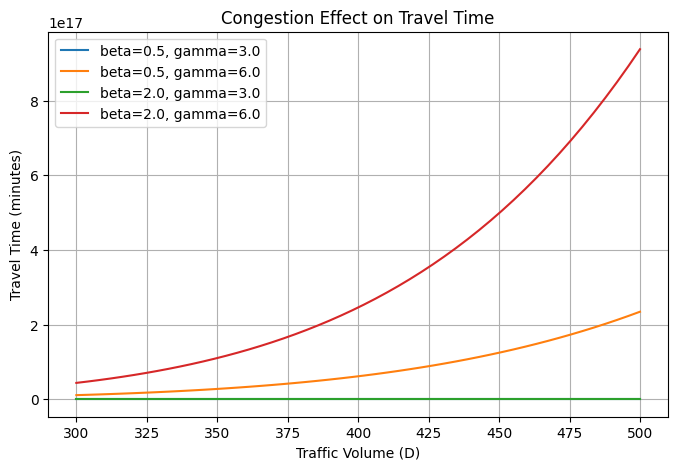

In [43]:
# Plot congestion function for different parameter values
D_test = np.linspace(300, 500, 50)
beta_values = [.5, 2.]  # Different congestion factors
gamma_values = [3., 6.]  # Different congestion non-linearity

plt.figure(figsize=(8, 5))
for beta in beta_values:
    for gamma in gamma_values:
        T_vals = congestion_function(D_test, beta, gamma)
        plt.plot(D_test, T_vals, label=f'beta={beta}, gamma={gamma}')
plt.xlabel("Traffic Volume (D)")
plt.ylabel("Travel Time (minutes)")
plt.title("Congestion Effect on Travel Time")
plt.legend()
plt.grid()
plt.show()

In [44]:
selected_beta = beta_values[0]  # Fixed congestion factors
selected_gamma = gamma_values[0] # Fixed congestion non-linearity

### Generalized cost - Without tax

In [45]:
# Parameters
time_value = 100  # SEK/hour

# Generalized cost function
def generalized_cost(D, beta, gamma, tax=0):
    return time_value / 60 * congestion_function(D, beta, gamma) + tax

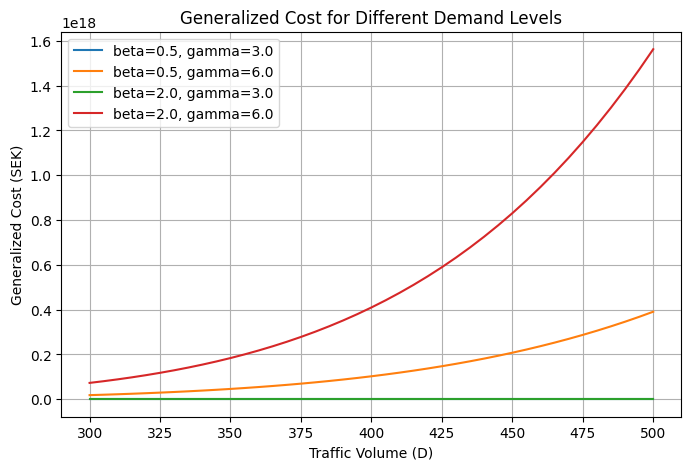

In [46]:
# Plot generalized cost for different demands using different beta and gamma
D_test = np.linspace(300, 500, 50)
plt.figure(figsize=(8, 5))
for beta in beta_values:
    for gamma in gamma_values:
        GC_vals = [generalized_cost(D, beta, gamma) for D in D_range]
        plt.plot(D_range, GC_vals, label=f'beta={beta}, gamma={gamma}')
plt.xlabel("Traffic Volume (D)")
plt.ylabel("Generalized Cost (SEK)")
plt.title("Generalized Cost for Different Demand Levels")
plt.legend()
plt.grid()
plt.show()

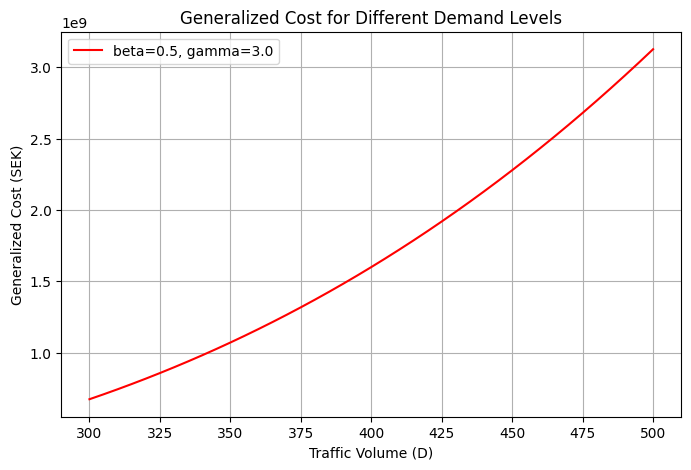

In [47]:
# Plot generalized cost for different demands using selected beta and gamma
D_range = np.arange(300, 501, 5)
GC_vals = [generalized_cost(D, beta=selected_beta, gamma=selected_gamma) for D in D_range]
plt.figure(figsize=(8, 5))
plt.plot(D_range, GC_vals, linestyle='-', color='r', label=f'beta={selected_beta}, gamma={selected_gamma}')
plt.xlabel("Traffic Volume (D)")
plt.ylabel("Generalized Cost (SEK)")
plt.title("Generalized Cost for Different Demand Levels")
plt.legend()
plt.grid()
plt.show()

### Consumer surplus - no tax

In [48]:
from scipy.integrate import quad

# Consumer surplus function
def consumer_surplus(D0, beta, gamma, tax=0):
    integral_value, _ = quad(lambda x: generalized_cost(x, tax, beta, gamma), 0, D0)
    GK0 = generalized_cost(D0, tax, beta, gamma)
    return integral_value - GK0 * D0

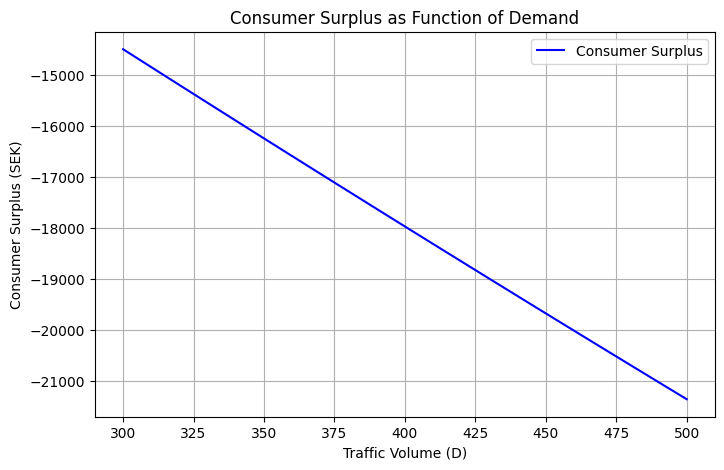

In [49]:
# Compute and plot consumer surplus
D_vals, GK_vals = demand_function(GK0=selected_GK0, slope=selected_slop, D_max=500)
CS_vals = np.cumsum(GK_vals) - GK_vals * D_vals
plt.figure(figsize=(8, 5))
plt.plot(D_vals, CS_vals, label='Consumer Surplus', color='b')
plt.xlabel("Traffic Volume (D)")
plt.ylabel("Consumer Surplus (SEK)")
plt.title("Consumer Surplus as Function of Demand")
plt.legend()
plt.grid()
plt.show()

## Net benefits

In [50]:
external_cost_factor = 0.1  # External cost per vehicle

# Net Benefit function
def net_benefit(D, beta, gamma, tax=0):
    CS = consumer_surplus(D, beta, gamma, tax)
    tax_revenue = D * tax
    external_costs = external_cost_factor * D
    return CS + tax_revenue - external_costs

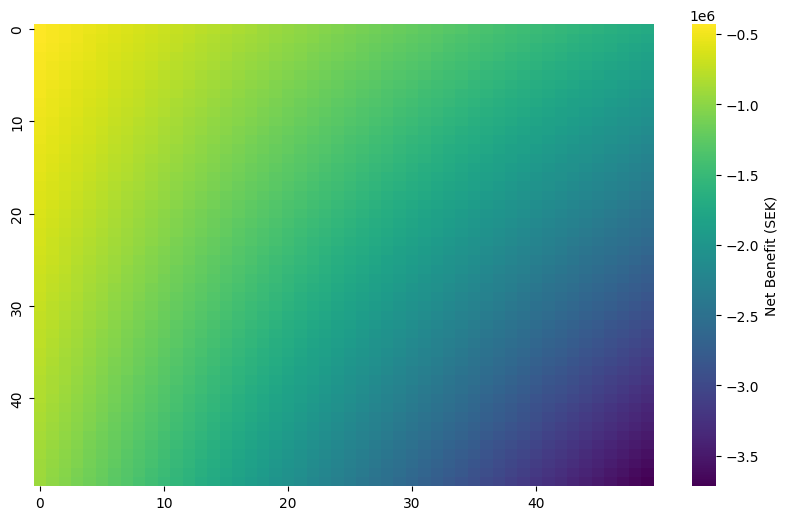

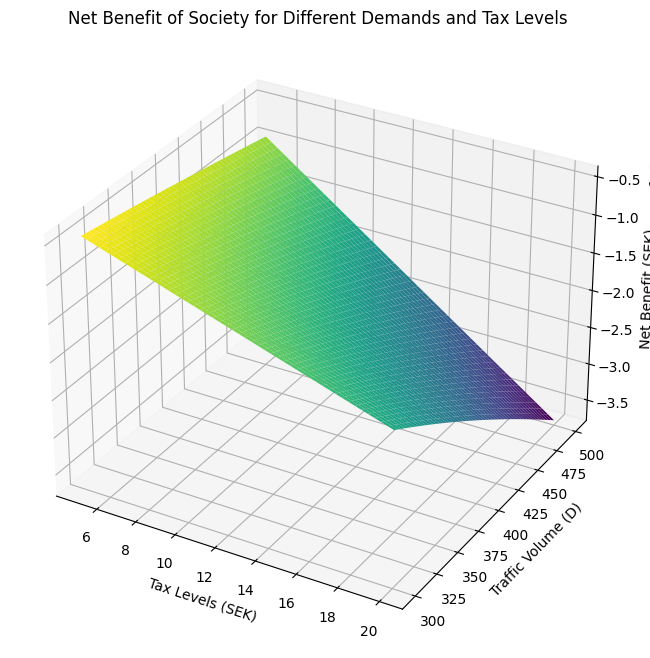

In [56]:
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

# Generate data for heatmap
D_range = np.linspace(300, 500, 50)
tax_levels = np.linspace(5, 20, 50)
net_benefit_matrix = np.zeros((len(D_range), len(tax_levels)))

for i, D in enumerate(D_range):
    for j, tax in enumerate(tax_levels):
        net_benefit_matrix[i, j] = net_benefit(D, beta=selected_beta, gamma=selected_gamma, tax=tax).sum()

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(net_benefit_matrix, xticklabels=10, yticklabels=10, cmap="viridis", cbar_kws={'label': 'Net Benefit (SEK)'})
# 3D plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
X, Y = np.meshgrid(tax_levels, D_range)
Z = net_benefit_matrix

ax.plot_surface(X, Y, Z, cmap='viridis')
ax.set_xlabel('Tax Levels (SEK)')
ax.set_ylabel('Traffic Volume (D)')
ax.set_zlabel('Net Benefit (SEK)')
ax.set_title('Net Benefit of Society for Different Demands and Tax Levels')
plt.show()

## Optimal congestion tax

In [52]:
# Optimal congestion tax function
def optimal_tax(D, beta, gamma):
    return time_value / 60 * (beta * gamma * D ** (gamma - 1)) + external_cost_factor

# Solve for optimal tax numerically
def find_optimal_tax(beta, gamma):
    result = minimize_scalar(lambda D: -optimal_tax(D, beta, gamma), bounds=(1, 500), method='bounded')
    return result.x, optimal_tax(result.x, beta, gamma)

In [53]:
# Print optimal tax results
for beta in beta_values:
    for gamma in gamma_values:
        D_opt, tau_opt = find_optimal_tax(beta, gamma)
        print(f"For beta={beta}, gamma={gamma}: Optimal traffic volume: {D_opt:.2f} vehicles, Optimal congestion tax: {tau_opt:.2f} SEK")

For beta=0.5, gamma=3.0: Optimal traffic volume: 500.00 vehicles, Optimal congestion tax: 625000.07 SEK
For beta=0.5, gamma=6.0: Optimal traffic volume: 500.00 vehicles, Optimal congestion tax: 156249979008208.81 SEK
For beta=2.0, gamma=3.0: Optimal traffic volume: 500.00 vehicles, Optimal congestion tax: 2499999.97 SEK
For beta=2.0, gamma=6.0: Optimal traffic volume: 500.00 vehicles, Optimal congestion tax: 624999916032835.00 SEK


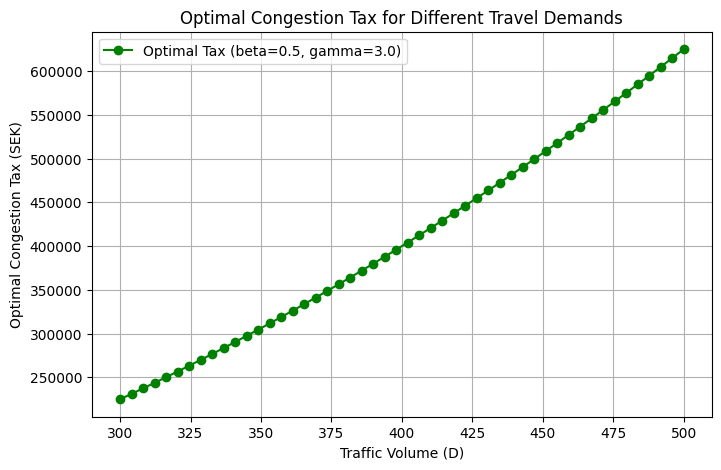

In [54]:
# Plot optimal congestion tax for different travel demands
D_range = np.linspace(300, 500, 50)
tax_vals = [optimal_tax(D, selected_beta, selected_gamma) for D in D_range]
plt.figure(figsize=(8, 5))
plt.plot(D_range, tax_vals, marker='o', linestyle='-', color='g', label=f'Optimal Tax (beta={selected_beta}, gamma={selected_gamma})')
plt.xlabel("Traffic Volume (D)")
plt.ylabel("Optimal Congestion Tax (SEK)")
plt.title("Optimal Congestion Tax for Different Travel Demands")
plt.legend()
plt.grid()
plt.show()